In [ ]:
import pandas   as pd
import numpy    as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import random
from sklearn.model_selection import cross_val_score
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# Obtain the necessary splits per the question


In [ ]:
df = pd.read_csv("Q1.csv")
train_df = df.head(500)
train_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,Y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.514801,0.481668,0.520128,0.512124,0.500548,0.502081,0.488875,0.484753,0.508864,0.482706,0.483879,0.508145,0.489282,0.472464,0.485698,0.504499,0.510494,0.490624,0.517622,0.504034,0.497389,0.493869,0.503740,0.506640,0.497811,0.535029,0.485474,0.490292,0.492113,0.522929,0.487476,0.498784,0.487493,0.516857,0.511430,0.498111,0.501423,0.505832,0.492730,0.499414,0.488992,0.500075,0.533906,0.470094,0.507622,0.752000
std,0.295187,0.298543,0.293535,0.290089,0.292258,0.286285,0.298829,0.292135,0.281657,0.287535,0.287904,0.286511,0.302355,0.288643,0.277382,0.285185,0.287572,0.294631,0.281592,0.289017,0.283364,0.286077,0.294055,0.289499,0.289154,0.273352,0.284800,0.287631,0.291352,0.295807,0.288069,0.290486,0.288538,0.279237,0.290158,0.291986,0.287055,0.284687,0.287317,0.295201,0.293213,0.279014,0.286835,0.296793,0.283360,0.432284
min,0.000668,0.000446,0.004856,0.001834,0.000361,0.007527,0.000434,0.006695,0.000996,0.002935,0.001004,0.002734,0.002288,0.001376,0.001294,0.007038,0.002072,0.000752,0.004078,0.000384,0.002251,0.000242,0.000517,0.001065,0.002102,0.003258,0.001307,0.000178,0.001075,0.000350,0.000027,0.004649,0.002868,0.001762,0.002330,0.000305,0.000825,0.000575,0.003232,0.000847,0.000656,0.000207,0.002609,0.000580,0.000341,0.000000
25%,0.251292,0.220175,0.257543,0.259588,0.246943,0.251284,0.227561,0.243866,0.256918,0.245593,0.231387,0.260389,0.212733,0.220528,0.249560,0.254729,0.247527,0.238056,0.293409,0.248053,0.261611,0.242835,0.268058,0.252014,0.246454,0.332982,0.236419,0.241621,0.246049,0.249278,0.236725,0.261236,0.234611,0.278084,0.241987,0.262353,0.266182,0.249991,0.249196,0.239401,0.228561,0.265223,0.304715,0.208401,0.268124,1.000000
50%,0.519801,0.465083,0.526273,0.526220,0.497766,0.524180,0.495666,0.468356,0.521302,0.499624,0.465247,0.506697,0.499939,0.437242,0.472110,0.521077,0.517066,0.485896,0.519794,0.518715,0.492390,0.509792,0.480486,0.511562,0.511021,0.526807,0.480541,0.475748,0.492353,0.556287,0.472448,0.492527,0.485642,0.531567,0.517983,0.496794,0.488722,0.530291,0.498622,0.519782,0.473961,0.500083,0.547491,0.438743,0.506942,1.000000
75%,0.774976,0.742483,0.780085,0.768798,0.754392,0.747965,0.756192,0.741953,0.756486,0.731373,0.744360,0.752228,0.744549,0.715175,0.725429,0.751429,0.758217,0.768270,0.754331,0.763480,0.734249,0.757178,0.764197,0.755644,0.751271,0.772292,0.720134,0.737929,0.731916,0.772374,0.740731,0.754961,0.737623,0.750124,0.761091,0.749775,0.764289,0.739531,0.726520,0.747697,0.749343,0.733583,0.781740,0.714219,0.747366,1.000000
max,0.997366,0.998952,0.999109,0.999347,0.998411,0.997375,0.998627,0.993070,0.999440,0.999254,0.999993,0.996959,0.999474,0.993146,0.995011,0.999646,0.999984,0.998658,0.997806,0.999531,0.996640,0.999554,0.999181,0.998807,0.999577,0.994540,0.998996,0.989115,0.999230,0.993965,0.998641,0.999359,0.998808,0.999904,0.999800,0.999169,0.993634,0.999237,0.998405,0.999110,0.995560,0.998831,0.999470,0.997870,0.997196,1.000000


In [ ]:
test_df = df.iloc[500:]
test_df= test_df.reset_index()
test_df

,index,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,Y
0,500,0.934557,0.569784,0.507193,0.972187,0.571631,0.233810,0.166002,0.300894,0.089415,0.694504,0.728187,0.885020,0.672651,0.363289,0.182659,0.249040,0.911086,0.721151,0.855473,0.502914,0.498897,0.338393,0.007965,0.032623,0.091115,0.351963,0.880808,0.107975,0.226217,0.569843,0.345740,0.790147,0.455112,0.058630,0.256274,0.236401,0.938508,0.434074,0.188457,0.528308,0.656080,0.471269,0.589084,0.742045,0.128162,1
1,501,0.039831,0.073547,0.008282,0.854687,0.713620,0.220989,0.048844,0.455284,0.163795,0.003109,0.154939,0.620146,0.445065,0.731371,0.238110,0.924438,0.487220,0.693126,0.328663,0.358298,0.541404,0.902102,0.514321,0.715780,0.388122,0.419840,0.910614,0.103794,0.403944,0.196214,0.447974,0.370565,0.237722,0.054045,0.462960,0.485288,0.041250,0.899801,0.937126,0.225071,0.715544,0.974248,0.969806,0.341422,0.820212,1
2,502,0.674065,0.920308,0.179792,0.354299,0.373502,0.650203,0.835878,0.771929,0.422745,0.885942,0.070811,0.207481,0.166842,0.467166,0.982156,0.515711,0.923804,0.392849,0.882839,0.388894,0.180741,0.076555,0.881233,0.136773,0.251112,0.037320,0.100935,0.005335,0.911543,0.717099,0.012851,0.810068,0.040698,0.235183,0.963397,0.714482,0.945443,0.029965,0.671941,0.614828,0.362520,0.066556,0.123705,0.184403,0.971088,1
3,503,0.903280,0.080657,0.731348,0.286939,0.654133,0.849936,0.104672,0.737325,0.453480,0.790292,0.695477,0.313647,0.195917,0.875608,0.158311,0.406343,0.686886,0.154946,0.152284,0.600961,0.186168,0.059978,0.454597,0.574417,0.277677,0.637153,0.014876,0.257372,0.877502,0.160941,0.358222,0.233331,0.462466,0.721367,0.078803,0.563392,0.066571,0.883715,0.238449,0.812971,0.809381,0.134383,0.821518,0.541259,0.269849,0
4,504,0.338011,0.587252,0.823871,0.795208,0.426851,0.823021,0.718881,0.174076,0.494510,0.833089,0.026423,0.781841,0.652970,0.357374,0.430359,0.149294,0.608177,0.303046,0.497198,0.715594,0.896014,0.325938,0.323274,0.609422,0.863773,0.903350,0.361270,0.011660,0.286052,0.752922,0.410177,0.055204,0.737326,0.857915,0.214799,0.252909,0.152316,0.980076,0.474807,0.567169,0.293423,0.564915,0.619584,0.351603,0.382677,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,645,0.731434,0.874143,0.538855,0.183450,0.659609,0.617381,0.316841,0.806301,0.915481,0.126482,0.580167,0.413642,0.942349,0.406753,0.615490,0.950294,0.834645,0.982278,0.846830,0.033811,0.238831,0.909474,0.545920,0.355524,0.131017,0.448491,0.582832,0.056711,0.497200,0.477787,0.484838,0.190483,0.190002,0.647205,0.212348,0.488024,0.377409,0.015978,0.937911,0.990918,0.444858,0.133169,0.163898,0.977617,0.794424,1
146,646,0.262779,0.517033,0.803949,0.037997,0.888330,0.939738,0.650766,0.911252,0.641786,0.426603,0.499324,0.335980,0.283663,0.690257,0.880108,0.421336,0.001755,0.800491,0.777512,0.291215,0.168573,0.462576,0.989821,0.850789,0.531557,0.724434,0.847870,0.547467,0.657029,0.735178,0.013396,0.618958,0.240594,0.135924,0.435367,0.836044,0.516094,0.219912,0.282812,0.365525,0.974071,0.112297,0.326315,0.425113,0.053601,0
147,647,0.731735,0.196605,0.913742,0.576471,0.271667,0.431978,0.462036,0.472162,0.237578,0.674204,0.030975,0.122069,0.259129,0.328399,0.691552,0.248406,0.809201,0.362097,0.155245,0.662454,0.780336,0.094251,0.078722,0.321476,0.931204,0.231650,0.553232,0.110802,0.969646,0.102379,0.766470,0.151050,0.784226,0.607723,0.175804,0.977174,0.270079,0.610286,0.621428,0.622714,0.469270,0.608335,0.689979,0.935384,0.671180,1
148,648,0.847800,0.315315,0.592467,0.966641,0.649618,0.748034,0.672155,0.643135,0.125029,0.239005,0.942127,0.328139,0.800377,0.685122,0.686504,0.685153,0.760078,0.889863,0.531128,0.203790,0.564912,0.798802,0.559347,0.161136,0.538762,0.437391,0.211448,0.742042,0.305911,0.240190,0.840282,0.154270,0.134215,0.346022,0.69

# Conduct Cross Validation

In [ ]:
cs =  np.linspace(0.0001, 0.6, 100, endpoint=True)
cs = cs.tolist()

In [ ]:
def crossval_split(dataset, n_folds):
    dataSplit = []
    dataCopy = dataset.copy()
    fold_size = int(dataCopy.shape[0]/n_folds)
    index = 0
    for _ in range(n_folds):
        fold = []
        while len(fold) < fold_size:
            fold.append(dataCopy.loc[index].values.tolist())
            dataCopy = dataCopy.drop(index)
            index += 1
        dataSplit.append(np.asarray(fold))
    return dataSplit

In [ ]:
def kfold_eval(dataset, n_folds, c_val, scorer):
    model = LogisticRegression(C=c_val, solver='liblinear', penalty='l1', random_state=0)
    data = crossval_split(dataset, n_folds)
    test_folds = dataset.shape[1] -1
    accuracies = []
    for i in range(n_folds):
        r = list(range(n_folds))
        r.pop(i)
        for j in r :
            if j == r[0]:
                cv = data[j]
            else:    
                cv = np.concatenate((cv,data[j]), axis=0)

        x_train = cv[:, :test_folds]
        y_train = cv[:, test_folds].astype('int64')
        x_test  = data[i][:,:test_folds]
        y_test  = data[i][:, test_folds].astype('int64')

        model.fit(x_train, y_train)
        
        if scorer == 'log_loss':
            pred = model.predict_proba(x_test)
            acc = log_loss(y_test, pred)
        elif scorer == 'accuracy':
            pred = model.predict(x_test)
            acc = accuracy_score(y_test, pred)
        accuracies.append(acc)
    return accuracies

In [ ]:
errors = []
cv_list = []
for c in cs:
    err = kfold_eval(train_df, 10, c, 'log_loss')
    cv_list.append(kfold_eval(train_df, 10, c, 'log_loss'))
    avg = sum(err)/10
    errors.append(avg)

In [ ]:
cv_array = np.array(cv_list)

In [ ]:
cv_df = pd.DataFrame(cv_array.T, columns=cs)
cv_df

,0.000100,0.006160,0.012219,0.018279,0.024338,0.030398,0.036458,0.042517,0.048577,0.054636,0.060696,0.066756,0.072815,0.078875,0.084934,0.090994,0.097054,0.103113,0.109173,0.115232,0.121292,0.127352,0.133411,0.139471,0.145530,0.151590,0.157649,0.163709,0.169769,0.175828,0.181888,0.187947,0.194007,0.200067,0.206126,0.212186,0.218245,0.224305,0.230365,0.236424,...,0.363676,0.369735,0.375795,0.381855,0.387914,0.393974,0.400033,0.406093,0.412153,0.418212,0.424272,0.430331,0.436391,0.442451,0.448510,0.454570,0.460629,0.466689,0.472748,0.478808,0.484868,0.490927,0.496987,0.503046,0.509106,0.515166,0.521225,0.527285,0.533344,0.539404,0.545464,0.551523,0.557583,0.563642,0.569702,0.575762,0.581821,0.587881,0.593940,0.600000
0,0.693147,0.693147,0.630347,0.590026,0.574793,0.567316,0.563052,0.560359,0.558380,0.556462,0.551021,0.543320,0.537341,0.532569,0.528818,0.526314,0.524485,0.523570,0.522900,0.522310,0.521752,0.521220,0.520840,0.520412,0.520040,0.519755,0.519477,0.519221,0.518988,0.518754,0.518559,0.518455,0.518247,0.518117,0.517978,0.517849,0.517716,0.517625,0.517542,0.517576,...,0.506225,0.505990,0.505765,0.505597,0.505457,0.505386,0.505228,0.505082,0.504966,0.504861,0.504710,0.504500,0.504327,0.504151,0.503984,0.503846,0.503733,0.503482,0.503290,0.503111,0.502975,0.502815,0.502688,0.502594,0.502454,0.502364,0.502234,0.502186,0.502107,0.502045,0.501995,0.501933,0.501923,0.501885,0.501872,0.501860,0.501867,0.501881,0.501914,0.501962
1,0.693147,0.693147,0.630347,0.590026,0.574793,0.567309,0.563041,0.560374,0.557138,0.551511,0.547394,0.544291,0.541865,0.539957,0.538556,0.536437,0.535252,0.534424,0.533849,0.533278,0.532876,0.532396,0.532026,0.531697,0.531403,0.531130,0.530894,0.530677,0.530436,0.530312,0.530096,0.529983,0.529830,0.529752,0.529635,0.529469,0.529514,0.529626,0.529452,0.529321,...,0.537824,0.538405,0.538970,0.539537,0.540092,0.540579,0.541018,0.541403,0.541973,0.542569,0.542845,0.543063,0.543054,0.543210,0.543250,0.543283,0.543324,0.543408,0.543474,0.543575,0.543783,0.543762,0.543896,0.544007,0.544147,0.544241,0.544407,0.544533,0.544694,0.544855,0.545040,0.545213,0.545350,0.545559,0.545717,0.545902,0.546112,0.546254,0.546470,0.546670
2,0.693147,0.693147,0.630347,0.590026,0.574793,0.567308,0.563041,0.560368,0.557193,0.553457,0.549166,0.541161,0.534674,0.528908,0.523734,0.519473,0.516096,0.513283,0.511290,0.510669,0.510129,0.509719,0.509249,0.508862,0.508623,0.508223,0.507950,0.507712,0.507513,0.507303,0.507093,0.506891,0.506734,0.506612,0.506494,0.506473,0.506477,0.506548,0.506621,0.506681,...,0.510075,0.510564,0.511141,0.511758,0.512326,0.512874,0.513533,0.514142,0.514789,0.515423,0.516023,0.516587,0.517101,0.517640,0.518199,0.518732,0.519261,0.519796,0.520322,0.520805,0.521298,0.521797,0.522226,0.522799,0.523273,0.523723,0.524132,0.523670,0.523725,0.523748,0.523554,0.523406,0.523194,0.523045,0.523068,0.522771,0.522655,0.522536,0.522160,0.522281
3,0.693147,0.693147,0.638803,0.609550,0.600138,0.596281,0.594499,0.593630,0.592773,0.590073,0.587724,0.586238,0.585398,0.584928,0.584059,0.582424,0.580885,0.579732,0.579986,0.580214,0.580451,0.580697,0.580957,0.581191,0.581342,0.581609,0.581798,0.582020,0.582193,0.582333,0.582576,0.582794,0.582797,0.582992,0.583187,0.583304,0.583432,0.583581,0.583675,0.583728,...,0.573337,0.572720,0.572163,0.571650,0.571125,0.570675,0.570237,0.569827,0.569409,0.569051,0.568659,0.568338,0.568025,0.567760,0.567489,0.567246,0.567052,0.566876,0.566593,0.566457,0.566285,0.566193,0.565449,0.565032,0.564456,0.563660,0.563156,0.562061,0.561402,0.560600,0.559839,0.559183,0.558458,0.557794,0.557234,0.556484,0.555943,0.555061,0.554431,0.553760
4,0.693147,0.693147,0.638803,0.609550,0.600138,0.596281,0.594499,0.593636,0.592055,0.591180,0.591091,0.591460,0.592074,0.592838,0.593335,0.592615,0.591820,0.592094,0.592403,0.592725,0.593039,0.593364,0.593653,0.593963,0.594229,0.594503,0.594765,0.594992,0.595253,0.595490,0.595708,0.596086,0.597095,0.598045,0.599010,0.599877,0.600752,0.601670,0.602430,0.603263,...,0.603

In [ ]:
len(errors)

100

In [ ]:
c_ticks = np.asarray(cs)
c_ticks = c_ticks[::10]
print(c_ticks)

[1.00000000e-04 6.06959596e-02 1.21291919e-01 1.81887879e-01
 2.42483838e-01 3.03079798e-01 3.63675758e-01 4.24271717e-01
 4.84867677e-01 5.45463636e-01]


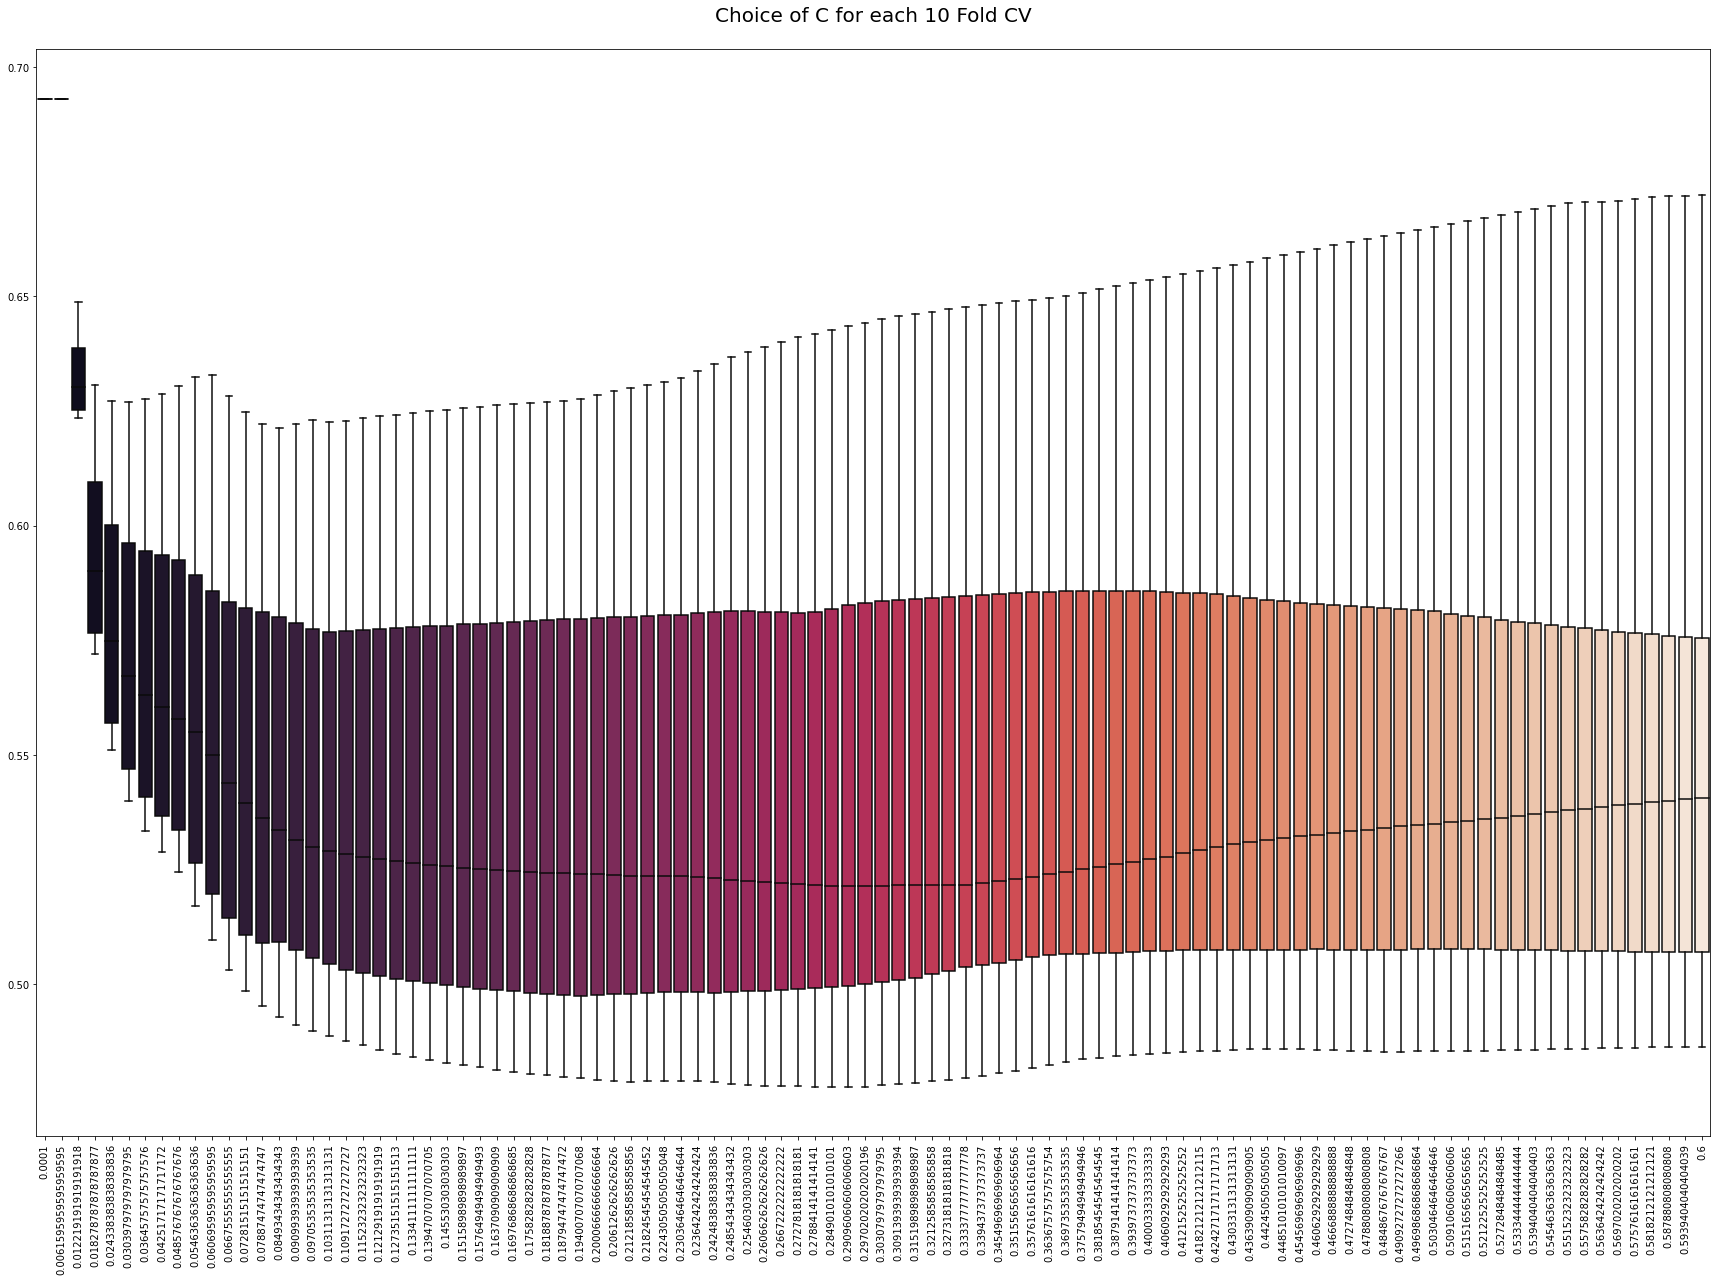

In [ ]:
fig, ax = plt.subplots(figsize=(30,20))

sns.boxplot(data=cv_df, palette="rocket")
plt.title('10-Fold CV', fontsize=20, y=1.02)
plt.xticks(rotation='vertical')
plt.xlabel("C_scores")
plt.ylabel("Cross Validation Score")
plt.tight_layout
plt.show() 

In [ ]:
res = []
min_c = 1
final_c = 0
for c in cs:
    mean = np.mean(kfold_eval(train_df, 10, c, 'log_loss'))
    res.append(mean)

    if mean < min_c:
        min_c = mean
        final_c = c
print(final_c) 

0.18794747474747472


In [ ]:
train_accuracy = np.mean(kfold_eval(train_df, 10, final_c, 'accuracy'))
test_accuracy = np.mean(kfold_eval(test_df, 10, final_c, 'accuracy'))
print("Training Accuracy: ", train_accuracy)
print("Testing Accuracy: ", test_accuracy)

Training Accuracy:  0.752
Testing Accuracy:  0.74


In [ ]:
np.random.seed(12)
model = LogisticRegression(penalty='l1', random_state=0, C=1, solver='liblinear')
def bootstrap(B, data):
    
    coefs = []
    
    x_train = data.iloc[:, :-1]
    y_train = data.iloc[:, -1]
    
    for i in range(B):
        x_choices = []
        y_choices = []
        boot_idx = np.random.choice(len(data), 500, replace=True)

        for id in boot_idx:
            x_choices.append(x_train.iloc[id])
            y_choices.append(y_train.iloc[id])
        
        model.fit(x_choices, y_choices)
        coefs.append(model.coef_[0])
        
    coefs = pd.DataFrame(coefs)
    return coefs


def get_stats(B, estimates):
    conf_interval = []
    means = []
    standerrs = []
    k = estimates.shape[1]
    for i in range(k):
        mean = np.mean(estimates.iloc[:,i])
        means.append(mean)

        sem = np.sqrt((1/(B-1)) * (np.std(estimates.iloc[:, i]))**2 * B)
        standerrs.append(sem)
        
        a = 5
        lower = np.percentile(estimates.iloc[:, i], a)
        upper = np.percentile(estimates.iloc[:, i], 100-a)
        conf_interval.append([lower, upper])
    return pd.DataFrame(conf_interval), pd.DataFrame(means), pd.DataFrame(standerrs)



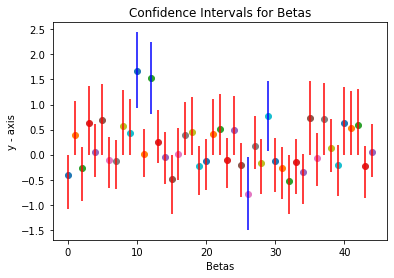

In [ ]:
B = 10000
estimates = bootstrap(B, train_df)
conf_inter, mean, stderr = get_stats(B, estimates)
lower, upper = conf_inter.iloc[:, 0], conf_inter.iloc[:, 1]


for i in range(45):
    if lower[i] <= 0 <= upper[i]:
        plt.vlines(i, lower[i], upper[i], colors='r', linestyles='solid')
        plt.scatter(i, mean.iloc[i, 0])
    else:
        plt.vlines(i, lower[i], upper[i], colors='b', linestyles='solid')
        plt.scatter(i, mean.iloc[i, 0])
    
plt.xlabel(r"Betas")
plt.ylabel("y - axis")
plt.title("Confidence Intervals for Betas")
plt.show()

In [ ]:
for i in range(45):
    if lower[i] <= 0 <= upper[i]:
        plt.vlines(i, lower[i], upper[i], colors='r', linestyles='solid')
        plt.scatter(i, mean.iloc[i, 0])
    else:
        plt.vlines(i, lower[i], upper[i], colors='b', linestyles='solid')
        plt.scatter(i, mean.iloc[i, 0])
    
plt.xlabel(r"Coefs")
plt.ylabel("y - axis")
plt.title("Confidence Intervals")
plt.show()

In [ ]:
grid_lr = GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=0),
                      cv=10,
                      param_grid=np.asarray(cs),
                      scoring='neg_log_loss')
grid_lr.fit(x_train, y_train)
grid_lr

AttributeError: ignored